### Smart City - Driver Behavior Sample

This sample showcases Object Detection task applied for vehicles and pedestrians recognition using sequence of neural networks.
Async API usage can improve overall frame-rate of the application, because rather than wait for inference to complete, the application can continue operating on the host while accelerator is busy.

This project consists on showcasing the advantages of the Intel’s OpenVINO toolkit. We will develop a Near Misses case scenario, where we will detect vehicles and pedestrians, track them across the video and estimate a metric of a crossroad’s dangerousness, based on proximity and sudden acceleration changes.

Other sample objectives are:

*	Video as input support via OpenCV
*	Visualization of the resulting vehicle and pedestrian bounding boxes from Vehicle and Pedestrian Detection network
*	Visualization of trajectory, speed and acceleration of every tracked object.
*	Visualization of near misses and collisions between vehicles.
*	Provide support for General Object Detection network as it is yolo-v3.


## How it Works

*	The application reads command line parameters and loads up to two networks depending on `-m...` options family to the Inference Engine.
*	The application gets a frame (or batch of frames) from the OpenCV's VideoCapture.
*	The application performs inference on the frame detection network.
*	The application performs up to 2 simultaneous inferences, using the Vehicle and Pedestrian detection networks,  if they are specified in command line.
*	The application displays the results.

The new Async API operates with a new notion of the Infer Request that encapsulates the inputs/outputs and separates scheduling and waiting for result. For more information about Async API and the difference between Sync and Async modes performance, refer to **How it Works** and **Async API** sections in [Object Detection SSD, Async API Performance Showcase Sample](@ref InferenceEngineObjectDetectionSSDDemoAsyncApplication).


## Compiling

There are several source files in the `src/` directory: 

We have provided a CMakeLists file for compiling the application. Run the following cell to run the make command.
It's important to source the setupenv.sh file as it defines some env variables that enable compiling the sample for different OpenVINO versions.

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *

In [3]:
!mkdir build && cd build && . ../scripts/setupenv.sh && cmake -DNO_SOUND=ON ..

-- The C compiler identification is GNU 5.4.0
-- The CXX compiler identification is GNU 5.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- InferenceEngine_DIR=/opt/intel/openvino_2019.1.094/deployment_tools/inference_engine/share
-- CMAKE_MODULE_PATH=/opt/intel/openvino_2019.1.094/deployment_tools/inference_engine/share/../samples/cmake
-- Looking for inference engine configuration file at: /home/u25335/Reference-samples/iot-devcloud/cpp/share
-- Found InferenceEngine: /opt/intel/openvino_2019.1.094/deployment_tools/inference_engine/lib

In [18]:
!cd build && . ../scripts/setupenv.sh && make

[  5%] Built target format_reader
[ 41%] Built target ie_cpu_extension
[ 88%] Built target dlib
[ 92%] Built target gflags_nothreads_static
Scanning dependencies of target driver_behavior
[ 93%] Building CXX object CMakeFiles/driver_behavior.dir/src/main.cpp.o
[ 94%] Linking CXX executable intel64/Release/driver_behavior
[100%] Built target driver_behavior


This produces an executable [smart_city_tutorial]() in `build/intel64/Release/`. This executable takes in a number of different command line arguments. First, We copy it on the root directory to simplify the next commands.

Run the following cell to see the list: 

In [19]:
!cp build/intel64/Release/driver_behavior .

In [6]:
%%bash
export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/data/reference-sample-data/extension/ 
./driver_behavior -h

InferenceEngine: 
	API version ............ 1.6
	Build .................. custom_releases/2019/R1_c9b66a26e4d65bb986bb740e73f58c6e9e84c7c2


/opt/intel/openvino_2019.1.094/deployment_tools/tools/model_downloader/Retail/object_reidentification/face/mobilenet_based/dldt/face-reidentification-retail-0095.xml
/opt/intel/openvino_2019.1.094/deployment_tools/tools/model_downloader/Retail/object_attributes/landmarks_regression/0009/dldt/landmarks-regression-retail-0009.xml

interactive_face_detection [OPTION]
Options:

    -h                         Print a usage message.
    -i "<path>"                Optional. Path to an video file. Default value is "cam" to work with camera.
    -m "<path>"                Required. Path to an .xml file with a trained face detection model.
    -m_ag "<path>"             Optional. Path to an .xml file with a trained age gender model.
    -m_hp "<path>"             Optional. Path to an .xml file with a trained head pose model.
    -m_em "<path>"             O

The version of the cpp file here is a slightly modified version of the smart_city_tutorial code in the original [**repo**](https://github.com/incluit/OpenVino-For-SmartCity).
In this version, the result is written into a output mp4 file if the `-o` flag is specified.

### Running the inference

Now we are ready to run the inference workload. In this step we will be submitting the workload as a job to the job queue.

Currently, you are on what is called a "devnode". On this system, you are allocated just one core on a large Intel® Xeon® CPU. The purpose of this node is to develop code on the devnode and run minimal sections of Jupyter* Notebooks, but it is not meant for compute intensive jobs like deep learning inference. So we need to request additional resources from the cluster of Edge nodes to run the inference, and this is done through the job queue.

To put an item on the job queue, we must first create a bash script that run the workload we want. Run the following cell to create bash script [smart_city_demo.sh](smart_city_demo.sh) which will be our job script. 

In [16]:
%%writefile driver_behavior_demo.sh
#PBS
DEVICE=$1
FP_MODEL=$2
VIDEO_INPUT=$3
OUTPUT_PATH=$4

if [ "$DEVICE" = "HETERO:FPGA,CPU" ]; then
    # Environment variables and compilation for edge compute nodes with FPGAs
    source /opt/fpga_support_files/setup_env.sh
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_bitstreams/2019R1_PL1_FP11_MobileNet_Clamp.aocx
fi

if [ "FP16" = "$2" ]; then
    fp_path='-fp16'
fi

cd $PBS_O_WORKDIR
export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/
source scripts/setupenv.sh && ./driver_behavior -m models/face-detection-retail-0004${fp_path}.xml -d $DEVICE -m_hp models/head-pose-estimation-adas-0001${fp_path}.xml -d_hp $DEVICE -dlib_lm -d_recognition -m_reid models/face-reidentification-retail-0095${fp_path}.xml -d_reid $DEVICE -m_lm models/landmarks-regression-retail-0009${fp_path}.xml -d_lm $DEVICE -i data/$VIDEO_INPUT -o $OUTPUT_PATH -no_show -fg scripts/faces_gallery.json

Overwriting driver_behavior_demo.sh


To put this script on the job queue, we use the command `qsub`.
There are two important arguments we use with this command.

First, the `-l` flag.
This flag is used to specify what type of resources to request from the cluster.
For example this can be used to request an Intel® Xeon® CPU based system, or it can be used to request a system with an FPGA accelerator card in it.
The syntax is `-l nodes=1:<tag>` where `<tag>` is the descriptor tag for the resource you want.
For example, `-l nodes=1:iei-tank-xeon` will request an Intel® Xeon® system.
To see the list of available tags, and the number of avilable systems, run the following cell.

In [ ]:
!pbsnodes | grep compnode | sort | uniq -c

Then there is the `-F` flag, which is used to pass in arguments to the job script.
The [smart_city_demo.sh](smart_city_demo.sh) takes in 4 arguments:

* 1) the path to the video to run inference on
* 2) targeted device (CPU,GPU,MYRIAD)
* 3) Single-or-Half-precision floating-point format (FP16, FP32)
* 4) Output directory

The job scheduler will use the contents of `-F` flag as the argument to the job script.

The following line will request an Intel Xeon system, and passes in "CPU FP32 data/video1.mp4 results/" to the job script. Run the cell to submit this job.

In [21]:
!mkdir -p results
#os.environ["VIDEO_INPUT"] = "video1.mp4"
#os.environ["VIDEO_INPUT"] = "video2.mp4"
os.environ["VIDEO_INPUT"] = "video3.mp4"
# video3 works much better (but slower) with the yolo network.

**Examples**

**Tracking:**
![tracking](images/tracking2.gif "tracking")
**Collision:**
![collision](images/collision.gif "collision")

#### Submitting to an edge compute node with an Intel® Core™ CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel 
    Core i5-6500TE</a>. The inference workload will run on the CPU.

In [22]:
print("Submitting job to Intel Core CPU...")
#Submit job to the queue
job_id_core = !qsub driver_behavior_demo.sh -l nodes=1:tank-870:i5-6500te -F "CPU FP32 $VIDEO_INPUT results/"
print(job_id_core[0])

#Progress indicators
if job_id_core:
    progressIndicator('results/', 'i_progress_'+job_id_core[0]+'.txt', "Inference", 0, 100)

Submitting job to Intel Core CPU...
45456.c003


#### Submitting to an edge compute node with Intel® Xeon® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel 
    Xeon Processor E3-1268L v5</a>. The inference workload will run on the CPU.

In [ ]:
print("Submitting job to Intel Xeon CPU...")
#Submit job to the queue
job_id_xeon = !qsub driver_behavior_demo.sh -l nodes=1:tank-870:e3-1268l-v5 -F "CPU FP32 $VIDEO_INPUT results/"
print(job_id_xeon[0])

#Progress indicators
if job_id_xeon:
    progressIndicator('results/', 'i_progress_'+job_id_xeon[0]+'.txt', "Inference", 0, 100)

Here you should see a output like "{job_id}.c003", where {job_id} is a number.
This is your job ID, and this value can be used to check on the progress of the job down the line.
Furthermore, the above job script has been written so that it uses its job_id as the name of the output video.   

One bigadvantage of the Job queue system is that you may submit multiple jobs at once. 
These jobs will be run as soon as resources are available, and may all run at once if the cluster is not busy.
Here are few other "preset" jobs that for your convenience that you can run. 

#### Submitting to an edge compute node with Intel® Core™ CPU and using the onboard Intel GPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500TE</a>. The inference workload will run on the Intel® HD Graphics 530 card integrated with the CPU.

In [ ]:
print("Submitting job to Intel Core CPU with Intel GPU...")
#Submit job to the queue
job_id_gpu = !qsub driver_behavior_demo.sh -l nodes=1:tank-870:i5-6500te -F "GPU FP32 $VIDEO_INPUT results"
print(job_id_gpu[0])

#Progress indicators
if job_id_gpu:
    progressIndicator('results/', 'i_progress_'+job_id_gpu[0]+'.txt', "Inference", 0, 100)

#### Submitting to an edge compute node with  IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a> . The inference workload will run on the <a href="https://www.ieiworld.com/mustang-f100/en/"> IEI Mustang-F100-A10 </a> card installed in this node.

In [ ]:
print("Submitting job to node with Intel FPGA HDDL-F...")
#Submit job to the queue
job_id_fpga = !qsub driver_behavior_demo.sh -l nodes=1:tank-870:i5-6500te:iei-mustang-f100-a10 -F "HETERO:FPGA,CPU FP32 $VIDEO_INPUT results/"
print(job_id_fpga[0])

#Progress indicators
if job_id_fpga:
    progressIndicator('results/', 'i_progress_'+job_id_fpga[0]+'.txt', "Inference", 0, 100)

#### Submitting to an edge compute node with Intel® Movidius™ Neural Compute Stick
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/movidius-ncs">Intel 
    Movidius Neural Compute Stick</a> installed in this node.

In [ ]:
print("Submitting job to node with Intel Movidius NCS...")
#Submit job to the queue
job_id_ncs = !qsub driver_behavior_demo.sh -l nodes=1:tank-870:i5-6500te:intel-ncs -F "MYRIAD FP16 $VIDEO_INPUT results/"
print(job_id_ncs[0])

#Progress indicators
if job_id_ncs:
    progressIndicator('results/', 'i_progress_'+job_id_ncs[0]+'.txt', "Inference", 0, 100)

#### Submitting to an edge compute node with Intel® Movidius™ Neural Compute Stick 2
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [ ]:
print("Submitting job to node with Intel NCS2...")
#Submit job to the queue
job_id_ncs2 = !qsub driver_behavior_demo.sh -l nodes=1:tank-870:i5-6500te:intel-ncs2 -F "MYRIAD FP16 $VIDEO_INPUT results/"
print(job_id_ncs2[0])

#Progress indicators
if job_id_ncs2:
    progressIndicator('results/', 'i_progress_'+job_id_ncs2[0]+'.txt', "Inference", 0, 100)

#### Submitting to an edge compute node with  IEI Mustang-V100-MX8 ( Intel® Movidius™ Myriad™ X Vision Processing Unit (VPU))
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://www.ieiworld.com/mustang-v100/en/">IEI Mustang-V100-MX8 </a>accelerator installed in this node.

In [ ]:
#Submit job to the queue
job_id_vpu = !qsub driver_behavior_demo.sh -l nodes=1:tank-870:i5-6500te:iei-mustang-v100-mx8 -F "HDDL FP16 $VIDEO_INPUT results/"
print(job_id_vpu[0])

#Progress indicators
if job_id_vpu:
    progressIndicator('results/', 'i_progress_'+job_id_vpu[0]+'.txt', "Inference", 0, 100)

#### Submitting to an edge compute node with UP Squared Grove IoT Development Kit (UP2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/up-squared-grove-dev-kit">UP Squared Grove IoT Development Kit</a> edge node with an <a 
    href="https://ark.intel.com/products/96488/Intel-Atom-x7-E3950-Processor-2M-Cache-up-to-2-00-GHz-">Intel Atom® x7-E3950 Processor</a>. The inference  workload will run on the integrated Intel® HD Graphics 505 card.

In [ ]:
#Submit job to the queue
job_id_up2 = !qsub driver_behavior_demo.sh -l nodes=1:up-squared -F "CPU FP32 $VIDEO_INPUT results/"
print(job_id_up2[0])

#Progress indicators
if job_id_up2:
    progressIndicator('results/', 'i_progress_'+job_id_up2[0]+'.txt', "Inference", 0, 100)

The `qstat` command is used to track the progress of the jobs. 
We have provided a utility funtion "liveQstat()" that provide a live updating GUI for you.
Run the following cell to check on the progress of your earlier jobs.

In [ ]:
liveQstat()

Once the jobs are done. The following cell can be used to display the output. 
The videoHTML is a utility function provided in [demoutils.py](demoutils.py).
This takes one argument, which is the path to the video (see above for convention for the path name).

For your convenience we have stored the jobid from the above `qsub` commands, and the following cells 

In [23]:
videoHTML('IEI Tank (Intel Core CPU)', 
          ['results/output_' + job_id_core[0] + '.mp4'], 
          'results/stats_'+job_id_core[0]+'.txt')

In [ ]:
videoHTML('IEI Tank Xeon (Intel Xeon CPU)',
          ['results/output_'+job_id_xeon[0]+'.mp4'],
          'results/stats_'+job_id_xeon[0]+'.txt')

In [ ]:
videoHTML('IEI Intel GPU (Intel Core + Onboard GPU)', 
          ['results/output_'+job_id_gpu[0]+'.mp4'],
          'results/stats_'+job_id_gpu[0]+'.txt')

In [ ]:
videoHTML('IEI Tank + IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)',
          ['results/output_'+job_id_fpga[0]+'.mp4'],
          'results/stats_'+job_id_fpga[0]+'.txt')

In [ ]:
videoHTML('IEI Tank + Intel CPU + Intel Movidius NCS',
          ['results/output_'+job_id_ncs[0]+'.mp4'],
          'results/stats_'+job_id_ncs[0]+'.txt')

In [ ]:
videoHTML('IEI Tank + Intel CPU + Intel NCS2',
          ['results/output_'+job_id_ncs2[0]+'.mp4'],
          'results/stats_'+job_id_ncs2[0]+'.txt')

In [ ]:
videoHTML('IEI Tank + IEI Mustang-V100-MX8 (Intel® Movidius™ Myriad™ X Vision Processing Unit (VPU))',
          ['results/output_'+job_id_vpu[0]+'.mp4'],
          'results/stats_'+job_id_vpu[0]+'.txt')

In [ ]:
videoHTML('UP Squared Grove IoT Development Kit (UP2)',
          ['results/output_'+job_id_up2[0]+'.mp4'],
          'results/stats_'+job_id_up2[0]+'.txt')

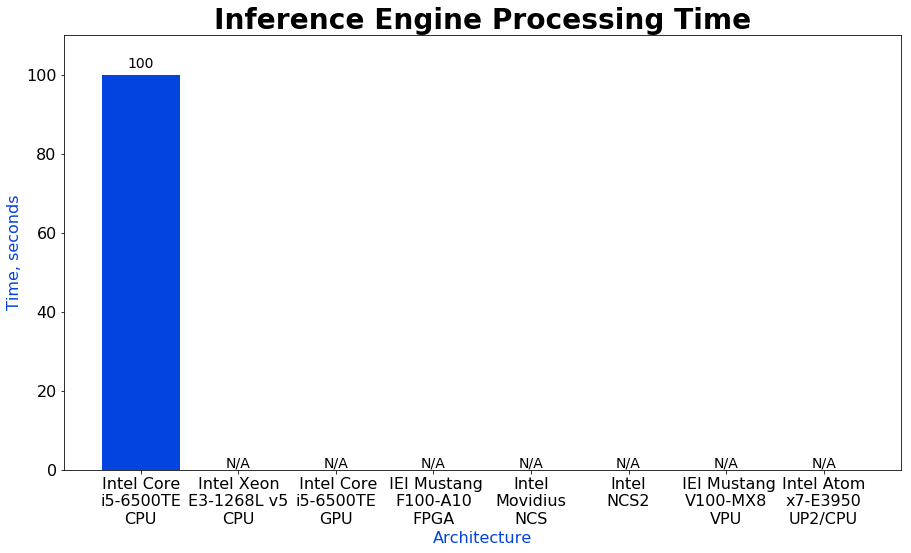

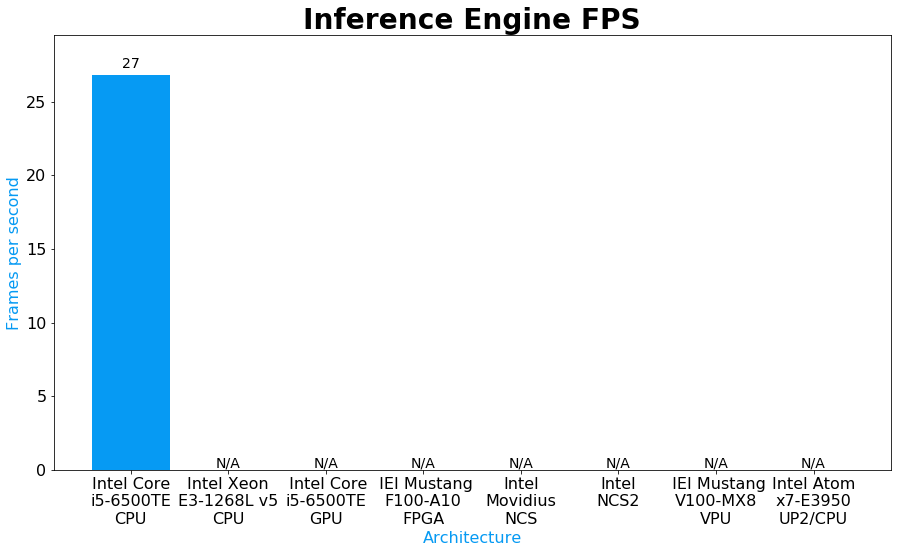

In [24]:
arch_list = [('core', 'Intel Core\ni5-6500TE\nCPU'),
             ('xeon', 'Intel Xeon\nE3-1268L v5\nCPU'),
             ('gpu', ' Intel Core\ni5-6500TE\nGPU'),
             ('fpga', ' IEI Mustang\nF100-A10\nFPGA'),
             ('ncs', 'Intel\nMovidius\nNCS'),
             ('ncs2', 'Intel\nNCS2'),
             ('vpu', ' IEI Mustang\nV100-MX8\nVPU'),
             ('up2', 'Intel Atom\nx7-E3950\nUP2/CPU')]

stats_list = []
for arch, a_name in arch_list:
    if 'job_id_'+arch in vars():
        stats_list.append(('results/stats_'+vars()['job_id_'+arch][0]+'.txt', a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )
summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )